# Robots Limpiadores
---

## Instrucciones

Considere que en una habitación con MxN espacios, hay P robots limpiadores reactivos. Cada uno de los robot limpiadores se comporta de la siguiente manera:

Si la celda en la que se encuentra está sucia, entonces aspira durante 10 segundos.
Si la celda está limpia, el robot elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas que esté sin otro robot) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda). Este movimiento dura 2 segundos.
Si varios robots coinciden en alguna de las celdas, uno se queda en dicha celda y los otros se tiene que mover a alguna otra celda. Quien se queda o quien se tiene que mover se elige aleatoriamente.
Al inicio de la simulación, las posiciones de los robots son elegidas al azar, y de igual forma las posiciones están limpias o sucias aleatoriamente.

Realiza al menos 5 simulaciones en este entorno con diferente número de robots, y reporta lo siguiente:

- Tiempo necesario hasta que todas las celdas estén limpias.
- Porcentaje de celdas limpias después del termino de la simulación.
- Número de movimientos realizados por todos los agentes.
- Analiza cómo la cantidad de agentes impacta el tiempo dedicado, así como la cantidad de movimientos realizados. ¿Qué comportamiento agregarías a los robots para que limpiaran con mayor velocidad?

## Solución

### Importar Librerías
Se importan las librerías necesarias para el entorno y el agente.

In [253]:
# Librerías para el agente y modelo
import agentpy as ap
import numpy as np

# Librearías de Visualización y otros
import matplotlib.pyplot as plt
import IPython, copy
plt.style.use('ggplot')

### Definición de las clases
Se define la clase agente ``CleaningRobot``, la cuál se encarga de simular a los robots limpiadores, y la clase de modelo ``CleaningRobotsModel``, la cuál se encarga de simular el entorno.

In [254]:
class CleaningRobot(ap.Agent):

    # Inicialización del agente
    def setup(self):
        self.moves = 0  # Numbero de movimientos
        self.state = -1  # -1: buscando, 0: limpiado, 1,2,3,4,5: limpiando

    # Función de acción del agente
    def next(self):
        currentPos = self.model.room.positions[self]

        # Si la celda está limpia, seguir buscando
        if self.model.room_state[currentPos] == 0:
            self.state = -1  # Estado de buscando
            self.move()  # Mover a posición aleatoria
            self.moves += 1  # Aumentar el número de movimientos;
            return

        if self.state == -1:  # Si se enceuntra una celda se comienza a limpiar
            self.state = 5
        elif self.state > 0:  # Si se está limpiando, seguir limpiando
            self.state -= 1
        else:                 # Si termina de limpiar, volver al estado de busqueda
            self.model.room_state[currentPos] = 0  # Se limpia la celda
            self.state -= -1

    # Mover a posición aleatoria
    def move(self):
        pos = self.getRandomPosition()
        self.model.room.positions[self] = pos

    # Obtener posición aleatoria
    def getRandomPosition(self):
        pos = False
        while pos == False:
            posM = self.model.random.randint(0, self.p.M - 1)
            posN = self.model.random.randint(0, self.p.N - 1)
            pos = (posM, posN)
            # Revisar si la posición está ocupada
            for robot in self.model.room.positions:
                if self.model.room.positions[robot] == pos:
                    pos = False
                    break
        return pos

In [255]:
class CleaningRobotsModel(ap.Model):
    def setup(self):
        # Inicialización de los robots
        self.robots = ap.AgentList(self, self.p.robots, CleaningRobot)

        # Inicialización de la habitación
        self.room = ap.Grid(self, [self.p.M, self.p.N], track_empty=True)
        self.room.add_agents(self.robots, random=True, empty=True)  # Añade los robots en posiciones aleatorias
        self.room_state = np.zeros([self.p.M, self.p.N]) # Estado de la habitación: limpia

        # Añadir celdas sucias aleatoriamente
        n_dirty_cells = int(self.p.M * self.p.M * self.p.dirty_cells) # Obtener el número de celdas sucias
        for _ in range(n_dirty_cells):
            row = self.random.randint(0, self.p.M - 1)
            col = self.random.randint(0, self.p.N - 1)
            # Si la celda está limpia, se pone sucia
            if self.room_state[row, col] == 0:
                self.room_state[row, col] = 1

    # Función paso
    def step(self):
        # Llamar acción de los robots
        self.robots.next()

        # Si la habitación está limpia, terminar
        if np.sum(self.room_state.flatten()) == 0:
            self.stop()

    # Función de Actualizado
    def update(self):
        # Guarda los movimientos de los robots
        n_moves = np.sum(np.array(self.robots.moves))
        self.record("Moves", n_moves)

        # Guarda la cantidad de celdas sucias
        n_dirty = np.sum(self.room_state.flatten())
        self.record("Dirty cells", n_dirty)

    # Función de fin
    def end(self):
        # Guarda los movimientos y el tiempo
        n_moves = np.sum(np.array(self.robots.moves))
        n_dirty = np.sum(self.room_state.flatten())
        self.report("Moves", n_moves)
        self.report("Time", 2 * self.t)
        self.report("Dirty cells", n_dirty)


### Función de animación
Se define la función ``animation_plot``, la cuál se encarga de animar el entorno.

In [256]:
def animation_plot(model, ax):
    # Crea una copia del estado de la habitación
    grid = copy.deepcopy(model.room_state)

    # Identifica a los robots
    for robot in model.robots:
        grid[model.room.positions[robot]] = 2

    color_dict = {
        0: "#E5E5E5",
        1: "#D62C2C",
        2: "#207567",
    }

    # Dibuja la habitación
    ap.gridplot(grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(
        f"Cleaning robots\n"
        f"Time-step: {model.t * 2}, Cels left: "
        f"{np.sum(model.room_state).flatten()}"
    )


### Simulación
Se definen los parámetros, se crea un objeto de la clase ``CleaningRobotsModel``, y se ejecuta la simulación.

In [257]:
parameters = {
  'M': 20,            # Number of rows
  'N': 10,            # Number of columns
  'robots': 5,        # Number of robots
  'dirty_cells': 0.2, # Percentage of dirty cells
  'steps': 100,       # Number of steps
}

In [258]:
fig, ax = plt.subplots()

# Crea un modelo y guarda la animación
model = CleaningRobotsModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)

# Inicia la simulación
IPython.display.HTML(animation.to_jshtml(fps=15))

## Resultados
Resultados obtenidos en la simulación.

#### Nueva lista de parámetros:

In [259]:
parametersList = [
  {
    'M': 20,            # Number of rows
    'N': 10,            # Number of columns
    'robots': 2,        # Number of robots
    'dirty_cells': 0.2, # Percentage of dirty cells
    'steps': 1000,       # Number of steps
  },
  {
    'M': 20,            # Number of rows
    'N': 10,            # Number of columns
    'robots': 5,        # Number of robots
    'dirty_cells': 0.2, # Percentage of dirty cells
    'steps': 1000,       # Number of steps
  },
  {
    'M': 20,            # Number of rows
    'N': 10,            # Number of columns
    'robots': 7,        # Number of robots
    'dirty_cells': 0.2, # Percentage of dirty cells
    'steps': 1000,       # Number of steps
  },
  {
    'M': 20,            # Number of rows
    'N': 10,            # Number of columns
    'robots': 10,        # Number of robots
    'dirty_cells': 0.2, # Percentage of dirty cells
    'steps': 1000,       # Number of steps
  },
  {
    'M': 20,            # Number of rows
    'N': 10,            # Number of columns
    'robots': 20,        # Number of robots
    'dirty_cells': 0.2, # Percentage of dirty cells
    'steps': 1000,       # Number of steps
  },
]

### Simulacion

Se simularon 5 escenarios con diferentes números de robots. Se obtuvieron los siguientes resultados:

In [260]:
data = {
  'Moves': [],
  'Dirty cells': [],
  'Time': [],
}
for parameter in parametersList:
    model = CleaningRobotsModel(parameter)
    result = model.run()
    data['Moves'].append(result.reporters['Moves'])
    data['Time'].append(result.reporters['Time'])
    data['Dirty cells'].append(result.reporters['Dirty cells'])
    

Completed: 627 steps
Run time: 0:00:00.325315
Simulation finished
Completed: 229 steps
Run time: 0:00:00.126025
Simulation finished
Completed: 175 steps
Run time: 0:00:00.107428
Simulation finished
Completed: 136 steps
Run time: 0:00:00.068207
Simulation finished
Completed: 80 steps
Run time: 0:00:00.061508
Simulation finished


### Gráficas

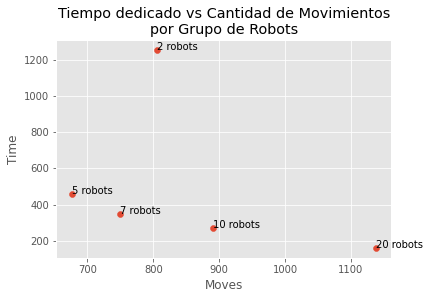

In [261]:
# Data
x = data['Moves']
y = data['Time']
names = ['2 robots', '5 robots', '7 robots', '10 robots', '20 robots']

# Plot
fig, ax = plt.subplots()
ax.scatter(x, y)

# Set labels
plt.xlabel('Moves')
plt.ylabel('Time')
plt.title('Tiempo dedicado vs Cantidad de Movimientos\npor Grupo de Robots')

for i, txt in enumerate(names):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

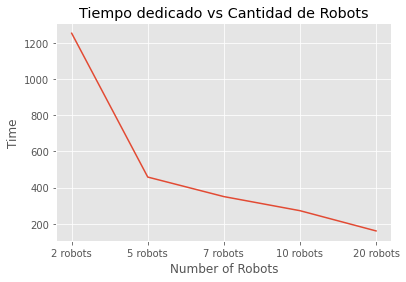

In [262]:
# Data
y = data['Time']
x = ['2 robots', '5 robots', '7 robots', '10 robots', '20 robots']

# Plot
fig, ax = plt.subplots()
ax.plot(x, y)

# Set labels
plt.xlabel('Number of Robots')
plt.ylabel('Time')
plt.title('Tiempo dedicado vs Cantidad de Robots')
plt.show()

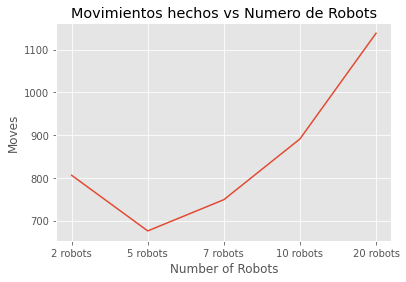

In [263]:
# Data
y = data['Moves']
x = ['2 robots', '5 robots', '7 robots', '10 robots', '20 robots']

# Plot
fig, ax = plt.subplots()
ax.plot(x, y)

# Set labels
plt.xlabel('Number of Robots')
plt.ylabel('Moves')
plt.title('Movimientos hechos vs Numero de Robots')
plt.show()

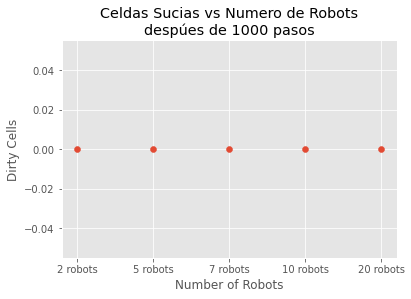

In [264]:
# Data
y = data['Dirty cells']
x = ['2 robots', '5 robots', '7 robots', '10 robots', '20 robots']

# Plot
fig, ax = plt.subplots()
ax.scatter(x, y)

# Set labels
plt.xlabel('Number of Robots')
plt.ylabel('Dirty Cells')
plt.title('Celdas Sucias vs Numero de Robots\ndespúes de 1000 pasos')
plt.show()

# Preguntas

- Tiempo necesario hasta que todas las celdas estén limpias.
  - Ver la gráfica ``Tiempo dedicado vs Cantidad de Robots``
- Porcentaje de celdas limpias después del termino de la simulación.
  - Ver la gráfica ``Celdas Sucias vs Numero de Robots despúes de 1000 pasos``
- Número de movimientos realizados por todos los agentes.
  - Ver la gráfica ``Movimientos hechos vs Numero de Robots``
- Analiza cómo la cantidad de agentes impacta el tiempo dedicado, así como la cantidad de movimientos realizados. ¿Qué comportamiento agregarías a los robots para que limpiaran con mayor velocidad?
  - Actualmente los robots solo se mueven a celdas libres, sin embargo, se podría añadir un "sensor" de tal forma que solo avance a celdas sucias. Esto se podría hacer repitiendo el randomInt hasta que de como resultado una celda sucia y no ocupada.